In [4]:
import os
import imageio
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.backends.cudnn as cudnn
import torchvision.utils as vutils
cudnn.benchmark = True

import pytorch3d
import pytorch3d.io


# some utility function for visualization
import utils
from utils.util_3d import init_mesh_renderer, sdf_to_mesh, add_mesh_textures

# some utility function
from utils.qual_util import save_mesh_as_gif
from IPython.display import Image as ipy_image
from IPython.display import display

%reload_ext autoreload
%autoreload 2

In [15]:
""" Load pre-trained model """
from utils.demo_util import Opt
from utils.demo_util import get_shape_comp_model, get_shape_comp_opt


opt = get_shape_comp_opt()
model = get_shape_comp_model(opt)
model.load_ckpt("saved_ckpt/rand_tf-snet_code-all-LR1e-4-clean-epoch200.pth")

[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: saved_ckpt/pvqvae-snet-all-LR1e-4-T0.2-rerun-epoch140.pth
[*] Model has been created: Rand-Transformer-Model
[*] "rand_tf" initialized.
[*] weight successfully load from: saved_ckpt/rand_tf-snet_code-all-LR1e-4-clean-epoch200.pth
[*] weight successfully load from: saved_ckpt/rand_tf-snet_code-all-LR1e-4-clean-epoch200.pth


In [16]:
from utils.demo_util import get_shape_comp_opt
from utils.demo_util import get_shape_comp_model

""" setup dir """
res_dir = 'results'
if not os.path.exists(res_dir): os.makedir(res_dir)

""" setup opt"""
gpu_id = 0

opt = get_shape_comp_opt(gpu_id=gpu_id)

""" setup different model """
model = get_shape_comp_model(opt)    
model.eval()

""" setup renderer """
dist, elev, azim = 1.7, 20, 110
mesh_renderer = init_mesh_renderer(image_size=256, dist=dist, elev=elev, azim=azim, device=opt.device)

[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: saved_ckpt/pvqvae-snet-all-LR1e-4-T0.2-rerun-epoch140.pth
[*] Model has been created: Rand-Transformer-Model
[*] "rand_tf" initialized.
[*] weight successfully load from: saved_ckpt/rand_tf-snet_code-all-LR1e-4-clean-epoch200.pth


# Shape Completion
1. Unconditional generation
2. Structured input (e.g., given a leg of a chair)

[*] autoregressively inferencing...: 100%|██████████| 512/512 [00:46<00:00, 11.07it/s]


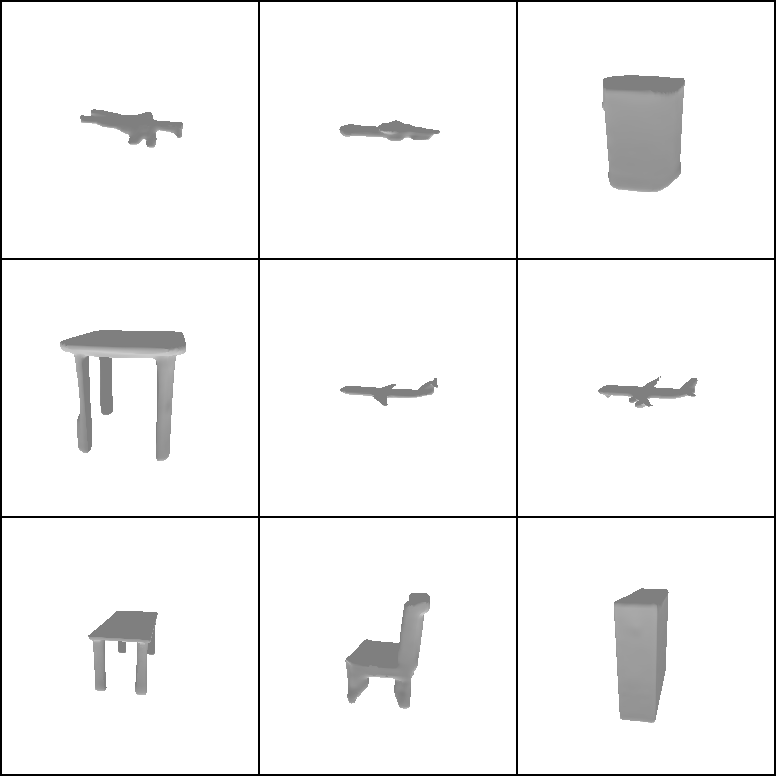

In [17]:
""" Shape completion 1 - unconditional generation """
gen_sdf = model.uncond_gen(bs=9, topk=30)
gen_sdf_as_mesh = sdf_to_mesh(gen_sdf)

# save as gif
gif_name = f'{res_dir}/shape-comp-uncond.gif'
save_mesh_as_gif(mesh_renderer, gen_sdf_as_mesh, nrow=3, out_name=gif_name)

ipy_image(gif_name)

In [28]:
"""
    Shape completion 2 - structured input
     - given a mesh, we first extract SDF from that mesh.
     - then user can specify the partial input by setting the min & max values of x, y, z.
"""
import utils
from utils.qual_util import get_partial_shape_by_range
from preprocess.process_one_mesh import process_obj

# input: complete chair
# first extract sdf from mesh
obj_file = 'demo_data/chair_model.obj'
sdf_file = process_obj(obj_file)

sdf = utils.util_3d.read_sdf(sdf_file).to(opt.device)

# range: -1 ~ 1.
# x: left-to-right; y: bottom-to-top; z: front-to-back
# example: only conditioning on the bottom of the chair
min_x, max_x = -1., 1.
min_y, max_y = -1., 0.
min_z, max_z = -1., 1.
input_range = {'x1': min_x, 'x2': max_x, 'y1': min_y, 'y2': max_y, 'z1': min_z, 'z2': max_z}

shape_comp_input = get_partial_shape_by_range(sdf, input_range)

[*] creating tmp/for_sdf/sdf/chair_model/isosurf.sdf
[*] trimesh_load: demo_data/chair_model.obj
[*] export_mesh:  tmp/for_sdf/norm_mesh/chair_model/pc_norm.obj
[*] command: ./preprocess/isosurface/computeDistanceField tmp/for_sdf/norm_mesh/chair_model/pc_norm.obj 256 256 256 -s  -e 1.3 -o 0.dist -m 1 -c
[*] command: mv 0.dist tmp/for_sdf/sdf/chair_model/isosurf.sdf


./preprocess/isosurface/computeDistanceField: error while loading shared libraries: libtbb_preview.so.2: cannot open shared object file: No such file or directory
mv: cannot stat '0.dist': No such file or directory


FileNotFoundError: [Errno 2] No such file or directory: 'tmp/for_sdf/sdf/chair_model/isosurf.sdf'

[*] autoregressively inferencing...: 100%|███████████████████████████████████████████████████| 256/256 [00:06<00:00, 41.82it/s]


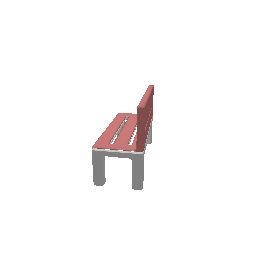

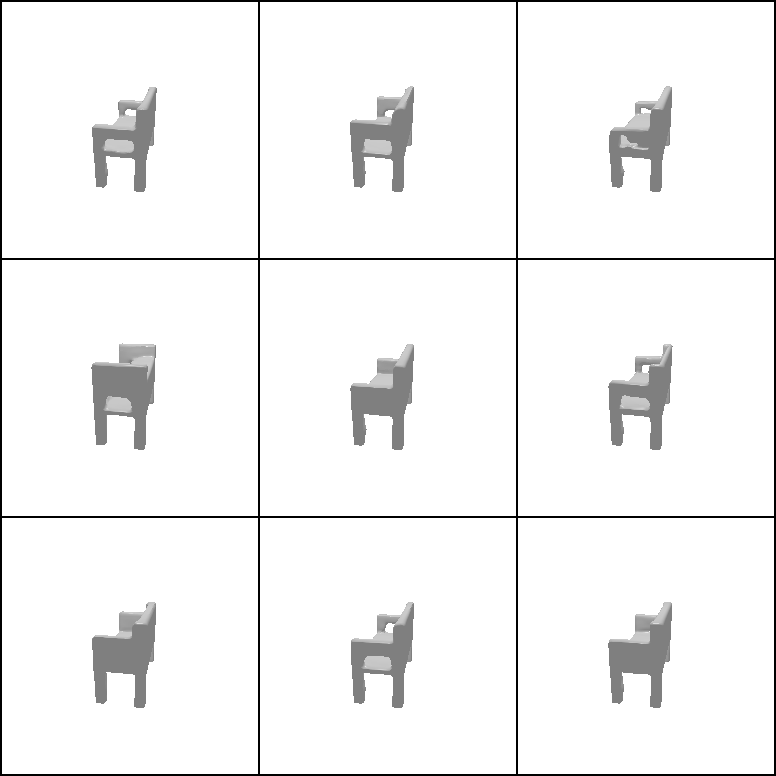

In [9]:
""" perform shape completion """
input_mesh, comp_sdf = model.shape_comp(shape_comp_input, bs=9, topk=30)

gen_mesh = sdf_to_mesh(comp_sdf)          # completed shape

# save as gif
gif_name = f'{res_dir}/shape-comp-struct-input-inp.gif'
save_mesh_as_gif(mesh_renderer, input_mesh, nrow=1, out_name=gif_name)

gen_gif_name = f'{res_dir}/shape-comp-struct-input-gen.gif'
save_mesh_as_gif(mesh_renderer, gen_mesh, nrow=3, out_name=gen_gif_name)

for name in [gif_name, gen_gif_name]:
    display(ipy_image(name))